This notebook, which serves as the preliminary stage of model development, supports text/data cleaning and exploration procedures. This includes stemming, stop-word analysis, tockenization, special characters, collocation analysis and so forth.

In [30]:
import pandas as pd
import numpy as np
import scipy as sp
import nltk
import re
import gc
import pickle
import os
from sklearn import decomposition
import seaborn
import matplotlib.pyplot as plt
import json

In [39]:
econdata = pd.read_csv("./data/economic-newstext-data.csv", encoding="latin-1", engine='python', header=0)
econdata.shape

(5015, 19)

<h2> Text/Data Cleaning </h2>

In [40]:
#Recognize columns with high-null values (beyond 50% threshold) for dropping courtesy extensive manipulation
nulls = econdata.apply(lambda s: sum(s.isnull())/len(econdata))
print(nulls[nulls>0.5])
econdata.drop(nulls[nulls>0.5].index.values, axis=1, inplace=True)

orig__golden       0.996610
positivity_gold    0.993021
relevance_gold     0.988634
dtype: float64


In [41]:
#Reconstructing entire news articles from dataset
econdata['text'] = econdata['text'].apply(lambda s: "" if pd.isnull(s) else s)
econdata['next_sentence'] = econdata['next_sentence'].apply(lambda s: "" if pd.isnull(s) else s)
fullarticle = econdata.groupby('articleid', sort=False)['text'].sum().reset_index(drop=True)
econdata = econdata[econdata['articleid']!=econdata['articleid'].shift(-1)].reset_index(drop=True)
econdata['text'] = fullarticle + econdata['next_sentence'].reset_index(drop=True)

In [42]:
econdata.drop(['articleid', 'date', 'lineid', 'previous_sentence', 'next_sentence', '_unit_id', '_golden',
              '_unit_state'], axis=1, inplace=True)

In [43]:
econdata.headline.values[0], econdata.text.values[0]

('Nasdaq Index Falls 1.7% But Dow Stocks Are Up: Nasdaq Index Falls 1.7%, But Dow Stocks Move Higher',
 'The stock market accelerated its screeching swerve away from Nasdaq stocks yesterday as investors piled into the Dow industrials and utilities.The Nasdaq composite index, home of technology companies large and small, fell 1.7 percent even as the Dow Jones industrial average rose 20.81 points, to 3,342.99.The bond market continued to rally, propelling (he normally placid ,\' Dow Jones utility average to a gain of 6.01\tpoints, or 2.5,6 percent, to 240.61 \x89ÛÓ the best one-day.advance, in percentage terms, in nearly five years. The yield on the 30-year Treasury bond fell to another record low. (Page \x89Û¢ D18.JThe Nasdaq market was stricken by the collapse of Synergen, a biotechnology company that lost more than tWo-thirds of its value after reporting discouraging test results for its most promising drug. With investors already fearing that the Clinton Administration will impose ti

In [44]:
#Text Cleaning: Removal special characters, case removal, stemming, stop words
def ascii_correction(s):
    s = s.encode('ascii', 'ignore').decode("utf-8").replace('\t', " ").replace("\\'", " ")
    s = re.sub("[^a-zA-Z0-9.,%']", " ", s).replace("  ", " ").replace(",","")
    return s.lower().replace("u.s.", "usa").replace("u.s", "usa") #To not interfere with period_correction
#Period correction: cleaner separation of words, unless period used as decimal point
def period_correction(s):
    potential = [pos for pos, char in enumerate(s) if char=="." and pos!=(len(s)-1)]
    num = ['0','1','2','3','4','5','6','7','8','9','10']
    error = [pos for pos in potential if s[pos-1] not in num or s[pos+1] not in num]
    if len(error)==0: return s
    def recursive(arr):
        if len(arr)==1: return " . "+s[arr[0]+1:]
        else: return " . "+s[arr[0]+1:arr[1]] + recursive(arr[1:])
    finalstr = s[:error[0]] + recursive(error)
    return finalstr.replace("  "," ")
for col in ['headline', 'text']: econdata[col]=econdata[col].apply(lambda s: period_correction(ascii_correction(s)))

In [45]:
econdata.headline.values[0], econdata.text.values[0]

('nasdaq index falls 1.7% but dow stocks are up nasdaq index falls 1.7% but dow stocks move higher',
 "the stock market accelerated its screeching swerve away from nasdaq stocks yesterday as investors piled into the dow industrials and utilities . the nasdaq composite index home of technology companies large and small fell 1.7 percent even as the dow jones industrial average rose 20.81 points to 3342.99 . the bond market continued to rally propelling he normally placid ' dow jones utility average to a gain of 6.01 points or 2.56 percent to 240.61 the best one day . advance in percentage terms in nearly five years . the yield on the 30 year treasury bond fell to another record low . page d18 . jthe nasdaq market was stricken by the collapse of synergen a biotechnology company that lost more than two thirds of its value after reporting discouraging test results for its most promising drug . with investors already fearing that the clinton administration will impose tight controls on healt

<h2> Text Exploration </h2>

In [64]:
#Word Frequency Overall and across Relevance
head = econdata.headline.apply(lambda s: s.split()).values
#Monoid flattening techniques, not suitable for production but theoretically elegant
headrel = sum(head[econdata.relevance=="yes"], [])
headnotrel = sum(head[econdata.relevance=="no"], [])
head = [word for case in head for word in case]
text = econdata.text.apply(lambda s: s.split()).values
textrel = sum(text[econdata.relevance=="yes"], [])
textnotrel = sum(text[econdata.relevance=="no"], [])
text = [word for case in text for word in case]

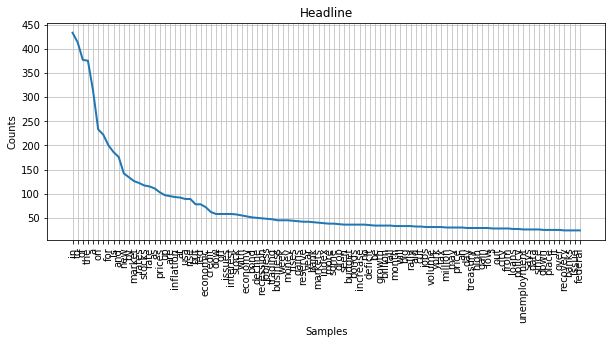

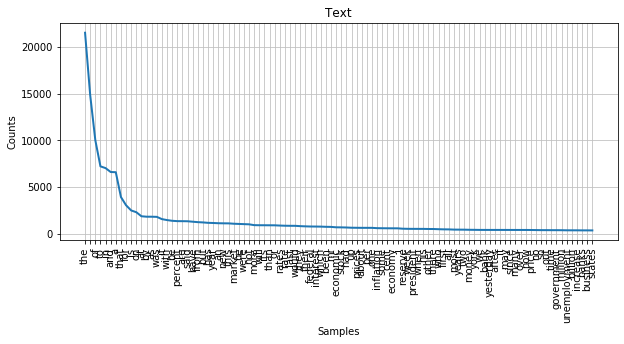

In [73]:
words = [head, text]
titles = ["Headline", "Text"]
for i in range(len(titles)):
    plt.figure(figsize=(10,4))
    plt.title(titles[i])
    nltk.probability.FreqDist(words[i]).plot(100)

In [ ]:
# Collocations and Concordance
sas = [nltk.Text(i) for i in words]


In [ ]:
#Dispersion plots

<h2> Dataset Separation </h2>